In [3]:
# Install dependencies
!pip install fastbook
!pip install ipywidgets

  Using cached fastbook-0.0.18-py3-none-any.whl (720 kB)
  Using cached fastai-2.5.3-py3-none-any.whl (189 kB)
  Using cached nbdev-1.1.23-py3-none-any.whl (46 kB)
  Using cached sentencepiece-0.1.96-cp39-cp39-win_amd64.whl (1.1 MB)
  Using cached scikit_learn-1.0.2-cp39-cp39-win_amd64.whl (7.2 MB)


You should consider upgrading via the 'C:\Users\aleck\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 7.1.2
    Uninstalling jupyter-client-7.1.2:
      Successfully uninstalled jupyter-client-7.1.2
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.4.0
    Uninstalling nbconvert-6.4.0:
      Successfully uninstalled nbconvert-6.4.0


You should consider upgrading via the 'C:\Users\aleck\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [27]:
# Import dependencies
import fastbook
fastbook.setup_book()
from fastbook import *
from ipywidgets import *
from fastai.vision.widgets import *

In [17]:
# Bing search key
key = os.environ.get('AZURE_SEARCH_KEY', '43e75ba8cc4e48558f4a625fa1e4f18b')

In [16]:
# Get images for each bill
billFolders = ['one dollar us bill', 'five dollar us bill', 'ten dollar us bill', 'twenty dollar us bill',
               'fifty dollar us bill','hundred dollar us bill']
path = Path('data')

# Create directories if needed
if not path.exists():
    path.mkdir()
    for billFolder in billFolders:
        # Create folder name
        billFolderName = billFolder.split()
        del billFolderName[2]
        billFolderName = "_".join(billFolderName)
        
        dest = (path/billFolderName)
        dest.mkdir(exist_ok=True)
        
        # Search bing for the bills
        results = search_images_bing(key, f'{billFolder}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [18]:
# Get folder images
fns = get_image_files(path)
fns

(#786) [Path('data/fifty_dollar_bill/00000000.jpg'),Path('data/fifty_dollar_bill/00000002.jpg'),Path('data/fifty_dollar_bill/00000003.png'),Path('data/fifty_dollar_bill/00000004.jpg'),Path('data/fifty_dollar_bill/00000005.jpg'),Path('data/fifty_dollar_bill/00000006.jpg'),Path('data/fifty_dollar_bill/00000007.png'),Path('data/fifty_dollar_bill/00000008.jpg'),Path('data/fifty_dollar_bill/00000009.jpg'),Path('data/fifty_dollar_bill/00000010.jpg')...]

In [19]:
# Remove corrupted images
failed = verify_images(fns)
failed.map(Path.unlink)

(#2) [None,None]

In [20]:
# Create datablock template
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


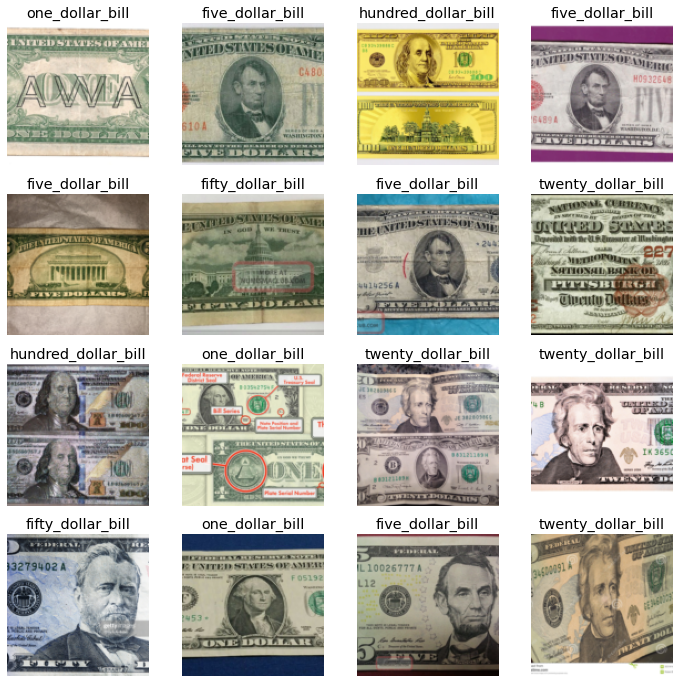

In [22]:
# Load data from directory
dl = db.dataloaders(path)
dl.valid.show_batch(max_n=16, nrows=4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\aleck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


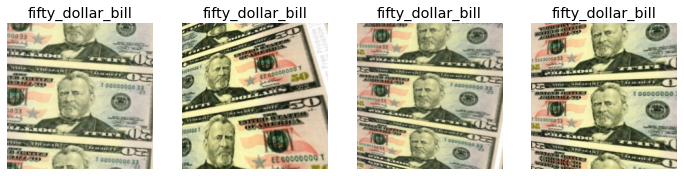

In [25]:
# Augment data and transform to same size
db = db.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dl = db.dataloaders(path)
dl.train.show_batch(max_n=4, nrows=1, unique=True)

In [26]:
# Train data with resnet, 18 layer neural network
model = cnn_learner(dl, resnet18, metrics=error_rate)
model.fine_tune(4)

# Note: Accuracy of model is 1 - error_rate

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\aleck/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.597113,1.914029,0.621795,01:28


C:\Users\aleck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.776589,1.422430,0.461538,02:09
1,1.512966,1.351803,0.378205,02:16
2,1.274601,1.326415,0.352564,02:12
3,1.089817,1.319175,0.346154,02:59


In [30]:
# Discard bad images
cleaner = ImageClassifierCleaner(model)
cleaner

In [31]:
# Remove bad data
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

# Move wrongly classified data to correct label
for idx, folder in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/folder)

In [32]:
# Re-train data with cleaned data
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)
db = db.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dl = db.dataloaders(path)

model = cnn_learner(dl, resnet18, metrics=error_rate)
model.fine_tune(4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,error_rate,time
0,2.755187,1.973372,0.692308,02:27


epoch,train_loss,valid_loss,error_rate,time
0,1.816251,1.507015,0.461538,03:03
1,1.475271,1.369269,0.384615,02:42
2,1.200712,1.272655,0.339744,02:40
3,1.057013,1.249326,0.333333,02:49


In [33]:
# Export model to pkl
model.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]